# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

В нашем распоряжении данные по бронированию номеров в сети отелей. Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Если клиент отменяет бронирование, то компания терпит убытки. Для решения этой задачи разработаем систему предсказания отказа от брони. Если модель предсказывает, что бронь будет отменена, то клиенту будет предлагаеться внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.  
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.
Стоимость номеров отеля:  
категория A: за ночь — 1 000, разовое обслуживание — 400;  
категория B: за ночь — 800, разовое обслуживание — 350;  
категория C: за ночь — 600, разовое обслуживание — 350;  
категория D: за ночь — 550, разовое обслуживание — 150;  
категория E: за ночь — 500, разовое обслуживание — 150;  
категория F: за ночь — 450, разовое обслуживание — 150;  
категория G: за ночь — 350, разовое обслуживание — 150.  
В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.  
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.  
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.  

Описание данных:  
id — номер записи;  
adults — количество взрослых постояльцев;  
arrival_date_year — год заезда;  
arrival_date_month — месяц заезда;  
arrival_date_week_number — неделя заезда;  
arrival_date_day_of_month — день заезда;  
babies — количество младенцев;  
booking_changes — количество изменений параметров заказа;  
children — количество детей от 3 до 14 лет;  
country — гражданство постояльца;  
customer_type — тип заказчика:  
        Contract — договор с юридическим лицом;  
   Group — групповой заезд;  
    Transient — не связано с договором или групповым заездом;  
    Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.  
days_in_waiting_list — сколько дней заказ ожидал подтверждения;  
distribution_channel — канал дистрибуции заказа;  
is_canceled — отмена заказа;  
is_repeated_guest — признак того, что гость бронирует номер второй раз;  
lead_time — количество дней между датой бронирования и датой прибытия;  
meal — опции заказа:  
SC — нет дополнительных опций;  
BB — включён завтрак;  
HB — включён завтрак и обед;  
FB — включён завтрак, обед и ужин.  
previous_bookings_not_canceled — количество подтверждённых заказов у клиента;  
previous_cancellations — количество отменённых заказов у клиента;  
required_car_parking_spaces — необходимость места для автомобиля;  
reserved_room_type — тип забронированной комнаты;  
stays_in_weekend_nights — количество ночей в выходные дни;  
stays_in_week_nights — количество ночей в будние дни;  
total_nights — общее количество ночей;  
total_of_special_requests — количество специальных отметок.

## 1. Загрузка данных

In [103]:
!pip install phik

In [104]:
!pip install imbalanced-learn

In [105]:
from imblearn.over_sampling import SMOTE

In [106]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_theme(palette='pastel')
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder

import statsmodels.api as sm

import phik
from phik.report import plot_correlation_matrix
from phik import report

pd.options.mode.chained_assignment = None

Загрузим файлы с данными:

In [107]:
df_train = pd.read_csv('/datasets/hotel_train.csv').copy()


In [108]:
df_test = pd.read_csv('/datasets/hotel_test.csv').copy()

Для вывода информации о файлах создадим функцию `info_df`:

In [109]:
def info_df(df):
    display(df.info())
    display(df.head())
    display(df.describe())
    df_train.hist(figsize=(16,14))
    plt.show()
    return

**df_train**. Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


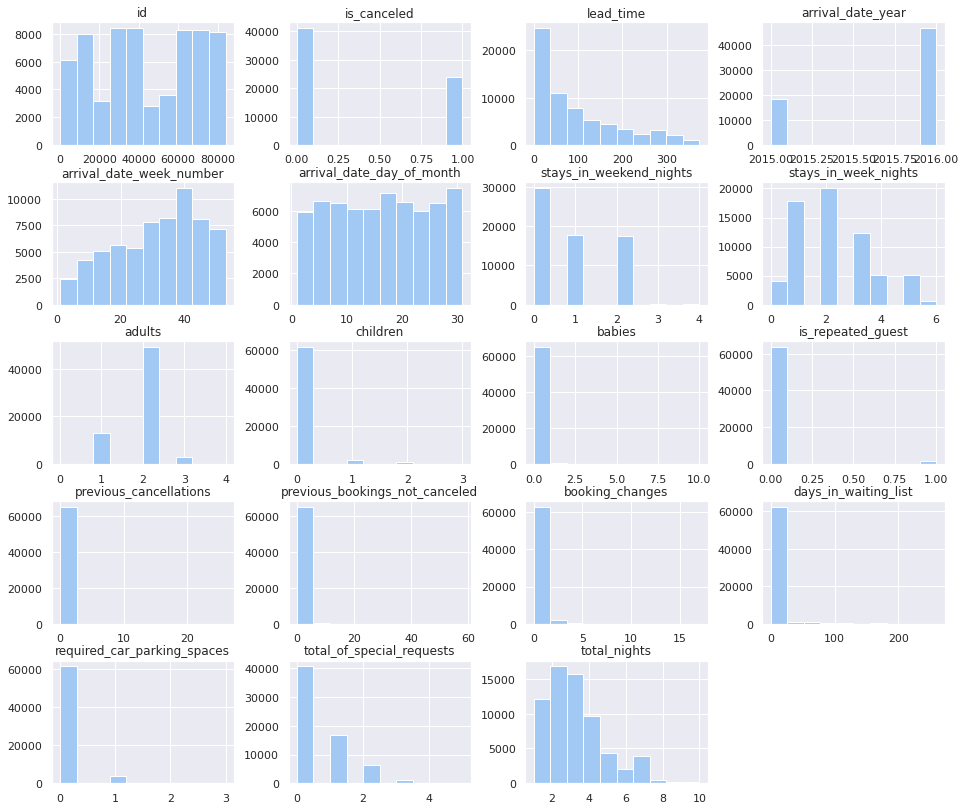

In [110]:
info_df(df_train)

interval columns not set, guessing: ['id', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']


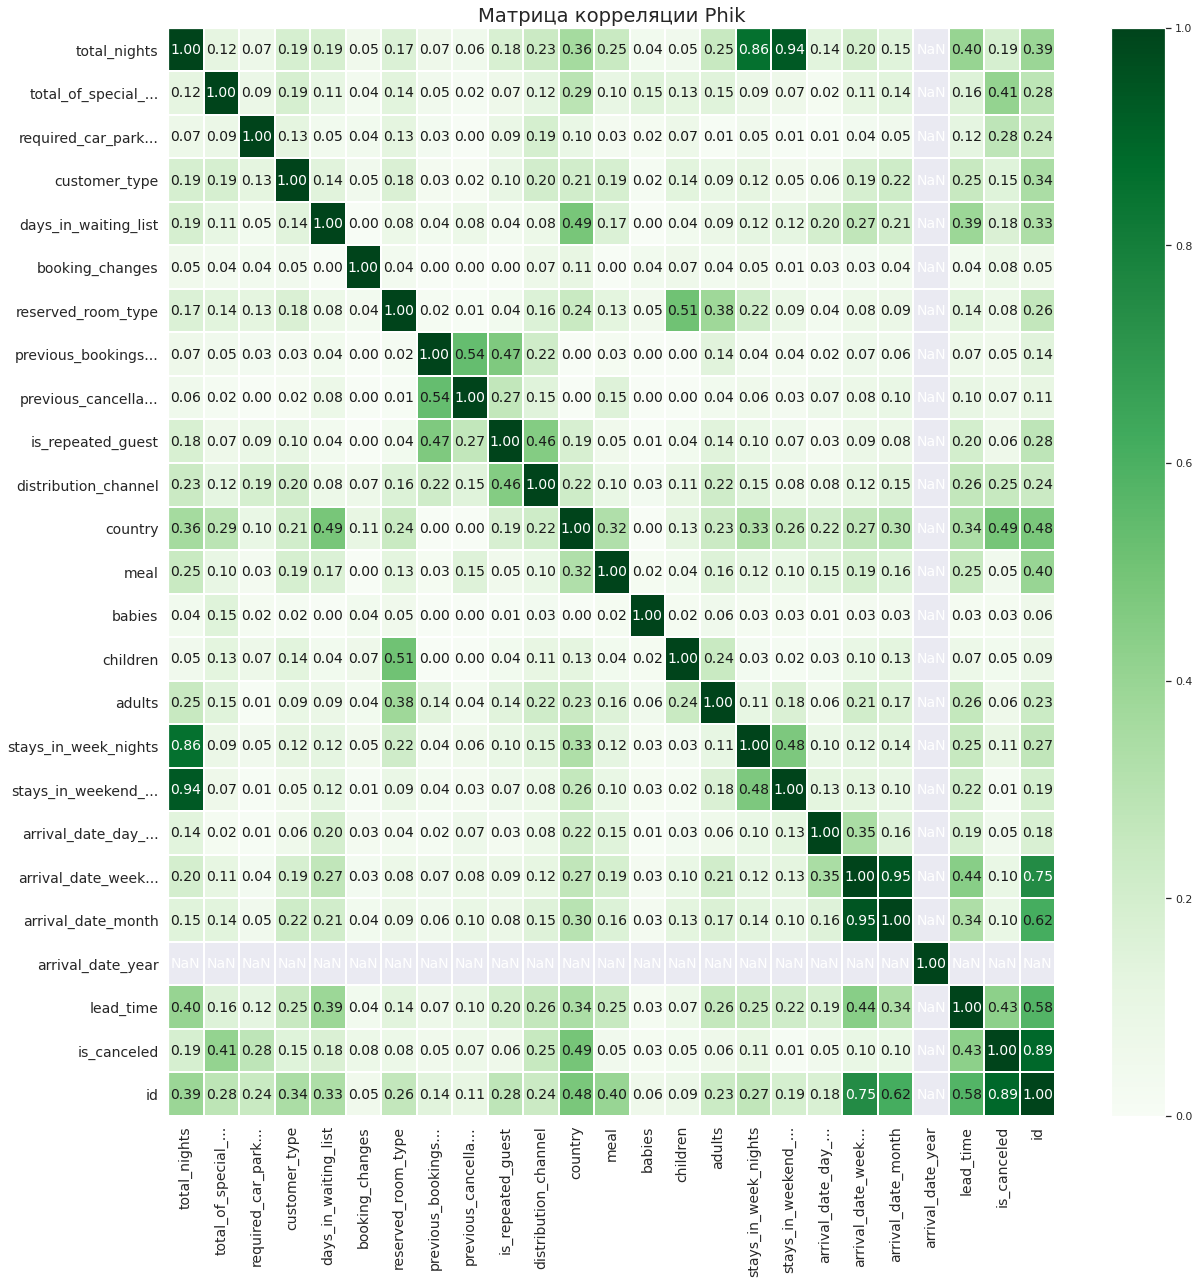

In [111]:
phik_overview = df_train.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title='Матрица корреляции Phik', 
                        fontsize_factor=1.4, 
                        figsize=(18, 18))
plt.tight_layout()

**df_test**. Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


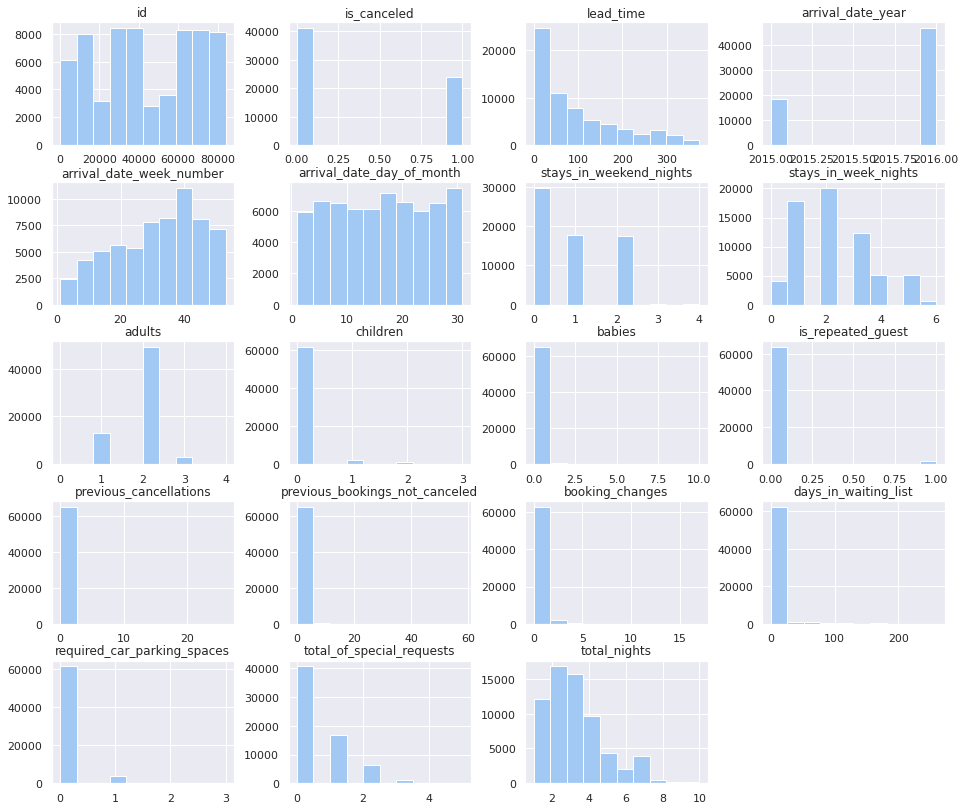

In [112]:
info_df(df_test)

**Вывод:**  
- Данные имеют 24 независимых признака и целевой признак `is_canceled`
- Пропуски данных отсутствуют;  
- Присутствуют аномальные значения в признаках;
- Тип данных в колонках не соответствует содержимому;
- Присутствует дисбаланс классов в целевом признаке;  
- Присутствует корреляция признаков.

In [113]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

## 2. Предобработка данных

Наименование колонок в змеином регистре, пропуски в данных отсутствуют. Проведем следующую предобработку данных::  
- проверим на явные дубликаты;  
- приведем в соответствие типы данных с содержимым;  
- обработаем аномальные значений.

Необходимые преобразования проводим в `df_train` и `df_test`

### 2.1 Изменение типов данных

Преобразуем колонки `lead_time`, `adults`, `children`, `babies` к целочисленному типу:

In [114]:
df_train[['lead_time', 'adults', 'children', 'babies']] = \
                            df_train[['lead_time', 'adults', 'children', 'babies']].astype('int16')
df_train.dtypes[['lead_time', 'adults', 'children', 'babies']]

lead_time    int16
adults       int16
children     int16
babies       int16
dtype: object

In [115]:
df_test[['lead_time', 'adults', 'children', 'babies']] = \
                            df_test[['lead_time', 'adults', 'children', 'babies']].astype('int16')
df_test.dtypes[['lead_time', 'adults', 'children', 'babies']]

lead_time    int16
adults       int16
children     int16
babies       int16
dtype: object

### 2.2 Поиск дубликатов

Проверим на явные дубликаты:

In [116]:
df_train.duplicated().sum()

0

Проверим уникальные значения в категориальных переменных:

**arrival_date_month**

In [117]:
df_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

**country**

In [118]:
df_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [119]:
df_test['country'].unique()

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

Заменим буквенный код страны CN на CNH:

In [120]:
df_train['country'] = df_train['country'].str.replace('CN', 'CHN')
df_test['country'] = df_test['country'].str.replace('CN', 'CHN')

**meal**

In [121]:
df_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [122]:
df_train['meal'] = df_train['meal'].str.strip()
df_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [123]:
df_test['meal'] = df_test['meal'].str.strip()
df_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

**distribution_channel**

In [124]:
df_train['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

**reserved_room_type**

In [125]:
df_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [126]:
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()
df_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [127]:
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()
df_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

**customer_type**

In [128]:
df_train['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [129]:
df_train.duplicated().sum()

0

In [130]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              65229 non-null  int64 
 1   is_canceled                     65229 non-null  int64 
 2   lead_time                       65229 non-null  int16 
 3   arrival_date_year               65229 non-null  int64 
 4   arrival_date_month              65229 non-null  object
 5   arrival_date_week_number        65229 non-null  int64 
 6   arrival_date_day_of_month       65229 non-null  int64 
 7   stays_in_weekend_nights         65229 non-null  int64 
 8   stays_in_week_nights            65229 non-null  int64 
 9   adults                          65229 non-null  int16 
 10  children                        65229 non-null  int16 
 11  babies                          65229 non-null  int16 
 12  meal                            65229 non-null

### 2.3 Обработка аномальных азначений

Проверим описательные статистики:

In [131]:
df_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Аномальные значения присутствуют у признаков: `lead_time`, `babies`, `previous_cancellations`, `previous_bookings_not_canceled`, `booking_changes`, `days_in_waiting_list`, `total_of_special_requests`. Проверим распределение данных в признаках:

**lead_time**. Проверим распределение признака в зависимости от целевого:

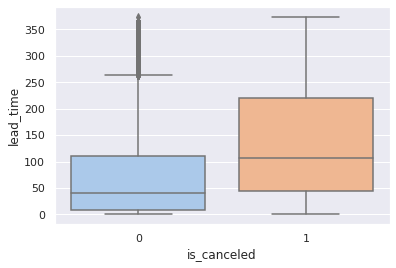

In [132]:
sns.boxplot(x=df_train['is_canceled'], y=df_train['lead_time'])
plt.show()

Аномальные значения признака попадают в основной интервал с признаком отмены бронирования. Данный факт считаем значимым - аномальные значения не убираем.

**babies**

In [133]:
df_train['babies'].value_counts()

0     64777
1       447
2         3
9         1
10        1
Name: babies, dtype: int64

In [134]:
df_train.shape

(65229, 25)

Аномальные значения: 9 и 10 детей. Удалим данные строки:

In [135]:
df_train = df_train[~(df_train['babies'] > 8)]
df_train.shape

(65227, 25)

**previous_cancellations**

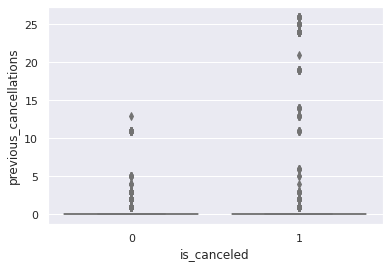

In [136]:
sns.boxplot(x=df_train['is_canceled'], y=df_train['previous_cancellations'])
plt.show()

Большая часть аномальных значений признака находятся в категории с признаком отмены бронирования. Аномальные значения не удаляем. Если у клиента зафиксированно более 13 отмен бронирования, дальнейшие бронирование отменяются со стороны клиента. Данного клиента можно считать "ненадежным"

**previous_bookings_not_canceled**

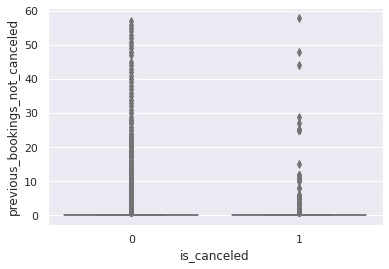

In [137]:
sns.boxplot(x=df_train['is_canceled'], y=df_train['previous_bookings_not_canceled'])
plt.show()

Большая часть аномальных значений признака находятся в категории с признаком подтверждения бронирования. Аномальные значения не удаляем

**booking_changes**

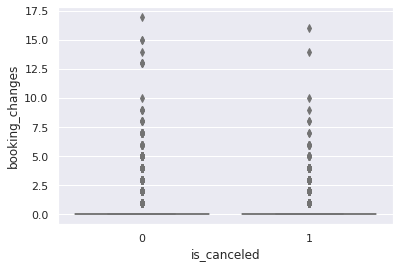

In [138]:
sns.boxplot(x=df_train['is_canceled'], y=df_train['booking_changes'])
plt.show()

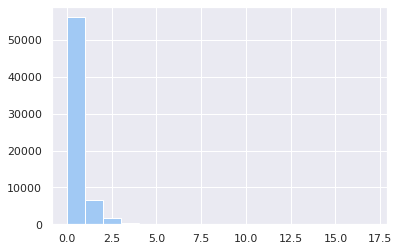

In [139]:
df_train['booking_changes'].hist(bins=17)
plt.show()

Проверим количество множественных изменений броней:

In [140]:
df_train[df_train['booking_changes'] > 3]['booking_changes'].count()

252

В основном в бронированиях происходит по одному изменению. Более 3х изменений характерны как для подтвержденных броней, так и для отмененных заказов. Отсавим данные без изменений.

**days_in_waiting_list**

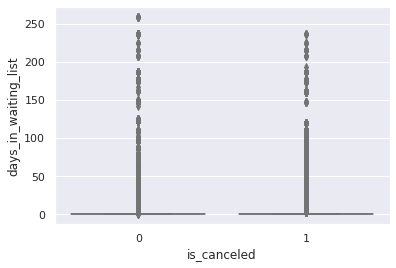

In [141]:
sns.boxplot(x=df_train['is_canceled'], y=df_train['days_in_waiting_list'])
plt.show()

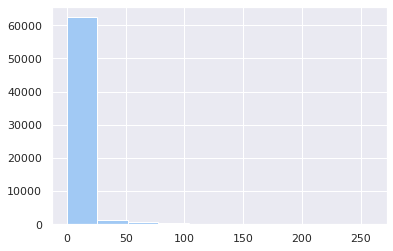

In [142]:
df_train['days_in_waiting_list'].hist()
plt.show()

Уберем выбросы методом quantile()

In [143]:
df_train = df_train[(df_train['days_in_waiting_list'] <= df_train['days_in_waiting_list'].quantile(0.995))]
df_train.shape

(64928, 25)

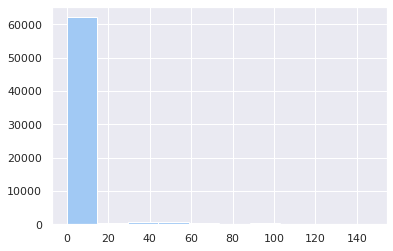

In [144]:
df_train['days_in_waiting_list'].hist()
plt.show()

**total_of_special_requests**

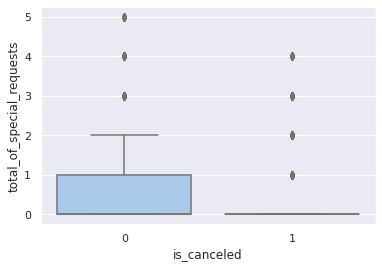

In [145]:
sns.boxplot(x=df_train['is_canceled'], y=df_train['total_of_special_requests'])
plt.show()

Данные оставляем без изменений, так как при наличии 5 специальных отметок бронь, как правило, является подтвержденной

In [146]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64928 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              64928 non-null  int64 
 1   is_canceled                     64928 non-null  int64 
 2   lead_time                       64928 non-null  int16 
 3   arrival_date_year               64928 non-null  int64 
 4   arrival_date_month              64928 non-null  object
 5   arrival_date_week_number        64928 non-null  int64 
 6   arrival_date_day_of_month       64928 non-null  int64 
 7   stays_in_weekend_nights         64928 non-null  int64 
 8   stays_in_week_nights            64928 non-null  int64 
 9   adults                          64928 non-null  int16 
 10  children                        64928 non-null  int16 
 11  babies                          64928 non-null  int16 
 12  meal                            64928 non-null

## 3. Исследовательский анализ данных

По результатам матрицы корреляции Phik, корреляцию с целевым признаком более 0.2 имеют признаки:  
    id - 0.89  
    country - 0.49  
    lead_time - 0.43  
    total_of_special_requests - 0.41  
    required_car_parking_spaces - 0.28  
    distribution_channel - 0.25  

Несмотря на высокое значение коэффициеента кореляции признака id,  данный признак не учитывем, так как он является уникальным идентификатором клиентов и привязывает прогнозирование к конкретному клиенту из прошлого, в чем нет необходимости при прогнозировании поведения новых клиентов.

Для проведения анализа создадим функцию `cancellation_table`, создающую сводную таблицу по признаку:

In [147]:
def cancellation_table(feature):  
    df = df_train.groupby(feature)['is_canceled'].agg(['count', 'sum']).sort_values(feature, ascending=False)
    df = df.rename(columns={'count': 'Количество бронирований', 'sum': 'Количество отмен брони'})
    df['Подтвержденные брони'] = df['Количество бронирований'] - df['Количество отмен брони']
    df['Доля отмен брони, %'] = round(df['Количество отмен брони'] / df['Количество бронирований'] * 100, 2)
    return df

**country**

In [148]:
df_country = cancellation_table('country')
df_country = df_country[df_country['Количество бронирований'] > 99].sort_values('Количество бронирований', ascending=False)
df_country

,Количество бронирований,Количество отмен брони,Подтвержденные брони,"Доля отмен брони, %"
country,,,,
PRT,28680,16477,12203,57.45
FRA,5934,876,5058,14.76
GBR,5101,938,4163,18.39
ESP,4899,1081,3818,22.07
DEU,3857,541,3316,14.03
ITA,2323,767,1556,33.02
IRL,1445,313,1132,21.66
BEL,1245,208,1037,16.71
NLD,1165,189,976,16.22


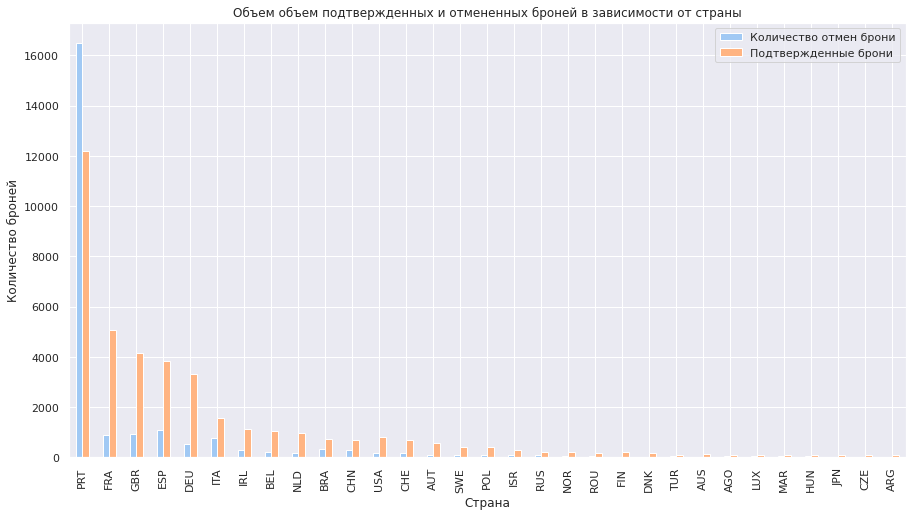

In [149]:
df_country.plot(y=['Количество отмен брони', 'Подтвержденные брони'], kind='bar', figsize=(15,8))
plt.title('Объем объем подтвержденных и отмененных броней в зависимости от страны')
plt.xlabel('Страна')
plt.ylabel('Количество броней')
plt.show()

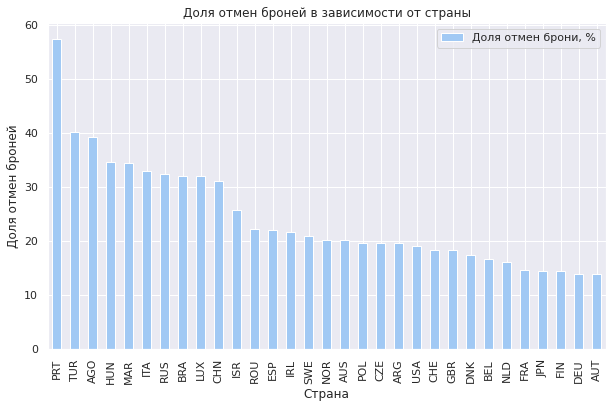

In [150]:
df_country.sort_values('Доля отмен брони, %', ascending=False).plot(y=['Доля отмен брони, %'], kind='bar', figsize=(10,6))
plt.title('Доля отмен броней в зависимости от страны')
plt.xlabel('Страна')
plt.ylabel('Доля отмен броней')
plt.show()

Для обучения моделей country будет являтся важным независимым признаком. Для оптимизации обучения, заменим названия стран с количеством наблюдений менее 100 на значение `other` в наборах данных `df_train` и `df_train`:

In [151]:
country_top = df_country.index
country_top

Index(['PRT', 'FRA', 'GBR', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'NLD', 'BRA',
       'CHN', 'USA', 'CHE', 'AUT', 'SWE', 'POL', 'ISR', 'RUS', 'NOR', 'ROU',
       'FIN', 'DNK', 'TUR', 'AUS', 'AGO', 'LUX', 'MAR', 'HUN', 'JPN', 'CZE',
       'ARG'],
      dtype='object', name='country')

In [152]:
df_train['country'].nunique()

154

In [153]:
df_train.loc[~df_train['country'].isin(country_top), 'country'] = 'other'
df_train['country'].nunique()

32

Аналогичную процедуру преобразования проведем в датафрейме df_test:

In [156]:
df_test['country'].nunique()

142

In [157]:
df_test.loc[~df_test['country'].isin(country_top), 'country'] = 'other'
df_test['country'].nunique()

32

**Вывод:** По стране PRT доля отмен бронирований превышает подтвержденные бронирования. Стоит обратить внимание на страны с долей отмен более 30%: CHN, TUR, AGO, HUN, MAR, ITA, RUS, BRA, LUX

**lead_time**

In [159]:
df_lead_time = cancellation_table('lead_time')
df_lead_time

,Количество бронирований,Количество отмен брони,Подтвержденные брони,"Доля отмен брони, %"
lead_time,,,,
374,20,20,0,100.00
373,1,0,1,0.00
372,33,33,0,100.00
367,20,20,0,100.00
365,61,52,9,85.25
...,...,...,...,...
4,994,109,885,10.97
3,1051,111,940,10.56
2,1156,119,1037,10.29


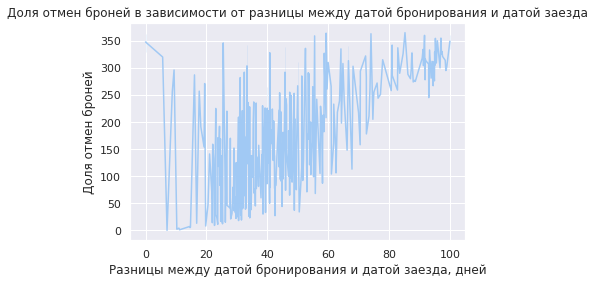

In [160]:
sns.lineplot(data=df_lead_time, x='Доля отмен брони, %', y='lead_time')
plt.title('Доля отмен броней в зависимости от разницы между датой бронирования и датой заезда')
plt.xlabel('Разницы между датой бронирования и датой заезда, дней')
plt.ylabel('Доля отмен броней')
plt.show()

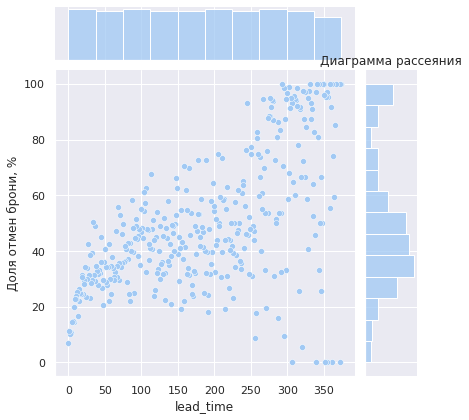

In [161]:
sns.jointplot(data=df_lead_time, x="lead_time", y="Доля отмен брони, %", kind='scatter')
plt.title('Диаграмма рассеяния')
plt.show()

**Вывод:** с учетом коробчатой диаграммы выводы следующие:  
 - с увеличением времени ожидания увеличивается доля отмен брони;  
 - при времени ожидания более 270 дней большая часть заказов отменяется.

**total_of_special_requests**

In [162]:
df_special_requests = cancellation_table('total_of_special_requests')
df_special_requests

,Количество бронирований,Количество отмен брони,Подтвержденные брони,"Доля отмен брони, %"
total_of_special_requests,,,,
5,13,0,13,0.00
4,107,13,94,12.15
3,1036,203,833,19.59
2,6443,1253,5190,19.45
1,16932,3074,13858,18.15
0,40397,19374,21023,47.96


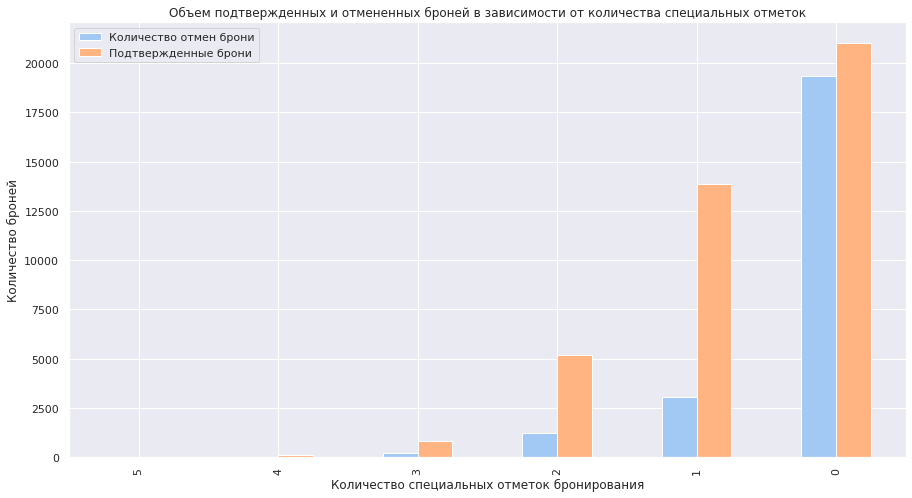

In [163]:
df_special_requests.plot(y=['Количество отмен брони', 'Подтвержденные брони'], kind='bar', figsize=(15,8))
plt.title('Объем подтвержденных и отмененных броней в зависимости от количества специальных отметок')
plt.xlabel('Количество специальных отметок бронирования')
plt.ylabel('Количество броней')
plt.show()

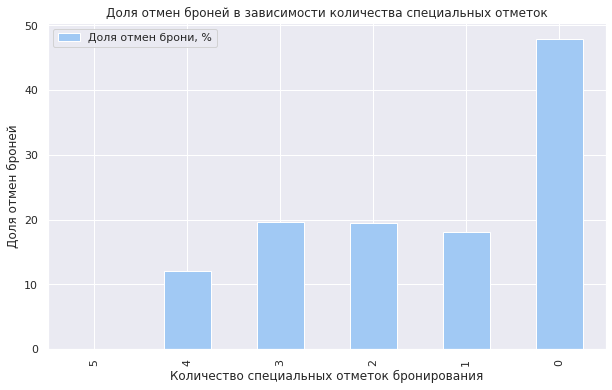

In [164]:
df_special_requests.plot(y=['Доля отмен брони, %'], kind='bar', figsize=(10,6))
plt.title('Доля отмен броней в зависимости количества специальных отметок')
plt.xlabel('Количество специальных отметок бронирования')
plt.ylabel('Доля отмен броней')
plt.show()

**Вывод:** Увеличение количества специальных отметок повышает вероятность подтверждения брони. При отсутствии специальных отметок, доля отмен бронирований более 47%

**required_car_parking_spaces**

In [165]:
df_special_requests = cancellation_table('required_car_parking_spaces')
df_special_requests

,Количество бронирований,Количество отмен брони,Подтвержденные брони,"Доля отмен брони, %"
required_car_parking_spaces,,,,
3,1,0,1,0.00
2,11,0,11,0.00
1,3670,0,3670,0.00
0,61246,23917,37329,39.05


**Вывод:** при наличие парковочного места бронирования подтверждаются. Доля отмененных бронирований, при отсутствии парковочного места, составляет 39%

**distribution_channel**

In [166]:
df_distribution_channel = cancellation_table('distribution_channel')
df_distribution_channel

,Количество бронирований,Количество отмен брони,Подтвержденные брони,"Доля отмен брони, %"
distribution_channel,,,,
TA/TO,54161,21879,32282,40.40
GDS,99,19,80,19.19
Direct,6846,1188,5658,17.35
Corporate,3822,831,2991,21.74


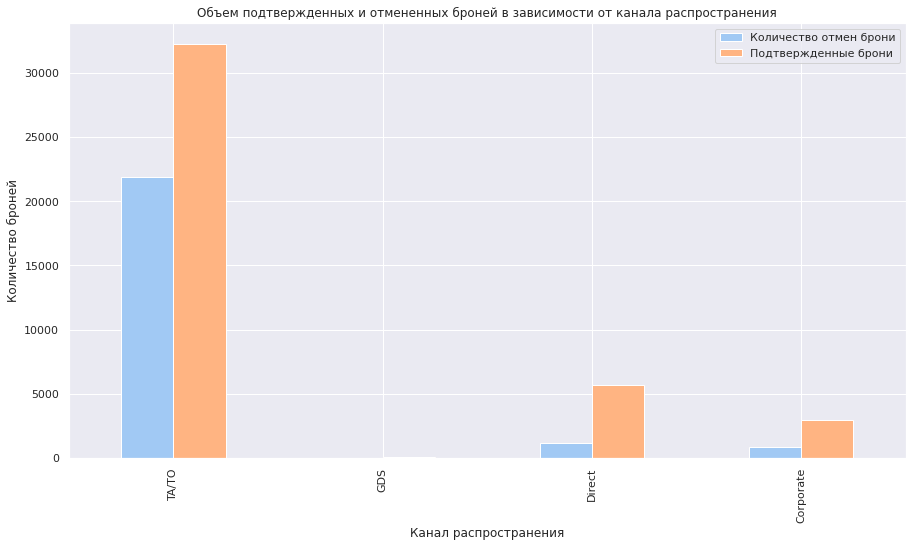

In [167]:
df_distribution_channel.plot(y=['Количество отмен брони', 'Подтвержденные брони'], kind='bar', figsize=(15,8))
plt.title('Объем подтвержденных и отмененных броней в зависимости от канала распространения')
plt.xlabel('Канал распространения')
plt.ylabel('Количество броней')
plt.show()

**Общий вывод:** наибольшее влияние на отмену бронирования имеют следующие факторы:
- Страна - Португалия. Доля отмен бронирований более 57%;  
- Время выполнения заказа. При увеличении времени выполнения заказа увеличивается доля отмен бронирований;  
- Наличие специальных отметок бронирования. При отсутствии отметок доля отмены бронирований более 47%;  
- Парковочное место. При отсутствии парквочного места доля отмен бронирования 39%;  
- Канал распространения бронирований - TA/TO. Доля отмен бронирований 40%;


## 4. Расчет прибыли

Для расчета прибыли бизнеса создадим три функции:  
- `season` - функция расчета сезонного коэффициента;  
- `profit_calculation` - функция расчета прибыли для каждого бронирования;  
- `profit_summary_table` - функция создания сводной таблицы для расчета итоговой прибыли.  

In [168]:
def season(month):
    if month == 'January' or month == 'February':
        return 1
    if month == 'March' or month == 'April' or month == 'May':
        return 1.2
    if month == 'June' or month == 'July' or month == 'August':
        return 1.4

In [169]:
def profit_calculation(row):
    if row['is_canceled'] == 1:
        return (-row['price_room_type'] - row['one_price_service']) * row['seasonal_coefficient']
    if row['is_canceled'] == 0:
        return (row['price_room_type'] * row['total_nights'] - row['one_price_service'] * ((1 + row['total_nights']) // 2)) * row['seasonal_coefficient']

In [170]:
def profit_summary_table(df):
    df_profit = df[['is_canceled', 'arrival_date_month', 'reserved_room_type', 'total_nights']]
    df_profit['price_room_type'] = df_profit['reserved_room_type'].map({'A': 1000, 'B': 800,\
                                                'C': 600, 'D': 550, 'E': 500, 'F': 450, 'G': 350})
    df_profit['one_price_service'] = df_profit['reserved_room_type'].map({'A': 400,\
                                                'B': 350, 'C': 350, 'D': 150, 'E': 150, 'F': 150, 'G': 150})
    df_profit['seasonal_coefficient'] = df_profit['arrival_date_month'].apply(season)
    df_profit['profit'] = df_profit.apply(profit_calculation, axis=1)
    
    return df_profit

In [171]:
test_profit = profit_summary_table(df_test)
test_profit

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_room_type,one_price_service,seasonal_coefficient,profit
0,1,January,A,1,1000,400,1.0,-1400.0
1,1,January,A,4,1000,400,1.0,-1400.0
2,1,January,A,4,1000,400,1.0,-1400.0
3,1,January,A,4,1000,400,1.0,-1400.0
4,1,January,A,7,1000,400,1.0,-1400.0
...,...,...,...,...,...,...,...,...
32407,0,August,A,6,1000,400,1.4,6720.0
32408,0,August,A,7,1000,400,1.4,7560.0
32409,0,August,A,7,1000,400,1.4,7560.0
32410,0,August,D,7,550,150,1.4,4550.0


In [172]:
total_profit = test_profit['profit'].sum()

In [173]:
print('Итоговая прибыль сети отелей за 8 месяцев:', total_profit)

Итоговая прибыль сети отелей за 8 месяцев: 31576250.0


## 5. Разработка моделей машинного обучения

Создадим модели для прогнозирования подтвержения или отмены бронирования. Используем три алгоритма машинного обучения:  
    - решающее дерево;  
    - случайный лес;  
    - логистическая регрессия.   

Для устранения дисбаланса классов в целевом признаке используем метод SMOTE.  

Для оценки качества моделей используем метрику f1.

Для отображения результатов обучения моделей создадим свобную таблицу `total_ml`:

In [174]:
total_ml = pd.DataFrame(columns=['Name_ml', 'Algorithm', 'f1', 'f1_std'])

### 5.1 Подготовка признаков

Создадим наборы данных использую результаты матрицы корреляции. Для набора данных с независимыми признаками берем следующие признаки:
- Наиболее коррелируемые с `is_canceled`: total_of_special_requests, distribution_channel, country, lead_time, required_car_parking_spaces;
- Наиболее коррелируемые с `lead_time`: total_nights, customer_type, days_in_waiting_list, arrival_date_week_number
- Наиболее коррелируемые с `distribution_channel`: is_repeated_guest, previous_bookings_not_canceled, adults
- Наиболее коррелируемые с `country`: reserved_room_type, meal, arrival_date_month, stays_in_weekend_nights, stays_in_week_nights

In [175]:
X_train = df_train[['arrival_date_month', 'reserved_room_type', 'meal', 'stays_in_weekend_nights', 'stays_in_week_nights','adults', 'previous_bookings_not_canceled', 'is_repeated_guest', 'total_nights', 'customer_type', 'days_in_waiting_list', 'country', 'lead_time', 'total_of_special_requests', 'required_car_parking_spaces', 'distribution_channel']].reset_index(drop=True)
y_train = df_train['is_canceled'].reset_index(drop=True)
X_train.shape

(64928, 16)

In [176]:
X_test = df_test[['arrival_date_month', 'reserved_room_type', 'meal', 'stays_in_weekend_nights', 'stays_in_week_nights','adults', 'previous_bookings_not_canceled', 'is_repeated_guest', 'total_nights', 'customer_type', 'days_in_waiting_list', 'country', 'lead_time', 'total_of_special_requests', 'required_car_parking_spaces', 'distribution_channel']].reset_index(drop=True)
y_test = df_test['is_canceled'].reset_index(drop=True)
X_test.shape

(32412, 16)

Для кодировки признаков применим OneHotEncoder из sklearn:

In [177]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
X_train_ohe = ohe.fit_transform(X_train[X_train.select_dtypes(include=['object']).columns])
X_columns = ohe.get_feature_names_out(X_train.select_dtypes(include=['object']).columns)
train_ohe = pd.DataFrame(X_train_ohe, columns=X_columns)

In [178]:
X_train_ohe.shape

(64928, 57)

In [179]:
X_test_ohe = ohe.transform(X_test[X_test.select_dtypes(include=['object']).columns])
test_ohe = pd.DataFrame(X_test_ohe, columns=X_columns)

In [180]:
test_ohe.shape

(32412, 57)

Соединим выборки с числовыми признаками и преобразованными категориальными:

In [181]:
number_train = X_train[X_train.select_dtypes(include=['int16', 'int64']).columns]
number_test = X_test[X_test.select_dtypes(include=['int16', 'int64']).columns]

In [182]:
X_train_ohe = pd.merge(number_train, train_ohe, left_index=True, right_index=True)
X_test_ohe = pd.merge(number_test, test_ohe, left_index=True, right_index=True)

После преобразования выборки X_train и X_test имеют одинаковое количество признаков.

В X_test отсутствуют признаки `'arrival_date_month_December'`, `'arrival_date_month_November'`, `'arrival_date_month_October'`, `arrival_date_month_September`, `'country_ARG'`, `'country_AUS'`, `'country_CZE'`, `'country_HUN'`, `'country_JPN'`, `'country_MAR'`, `'country_TUR'`.  Добавим признаки в набор данных и заполним нулевым значением: 

Устраним дисбаланс классов:

In [189]:
RANDOM_STATE = 25

In [190]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_ohe, y_train)
y_train_smote.value_counts()

0    41011
1    41011
Name: is_canceled, dtype: int64

### 5.2 Разработка моделей

#### 5.2.1 Решающее дерево

In [191]:
model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='entropy', max_depth=12,\
                                          min_samples_leaf=2, class_weight='balanced')
pipeline_dtc = make_pipeline(StandardScaler(), model_dtc)
pipeline_dtc.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=12,
                                        min_samples_leaf=2, random_state=25))])

In [192]:
scoring_dtc = cross_val_score(pipeline_dtc, X_train_smote, y_train_smote, cv=5, scoring='f1')
f1_dtc = scoring_dtc.mean()
f1_dtc

0.7605709934556144

In [193]:
f1_std_dtc = scoring_dtc.std()
f1_std_dtc

0.04432793613087401

In [194]:
total_ml = total_ml.append({'Name_ml': 'model_dtc', 'Algorithm': 'Decision Tree', 'f1': f1_dtc,\
                                    'f1_std': f1_std_dtc}, ignore_index=True)

#### 5.2.2 Случайный лес

In [195]:
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=50, criterion='entropy', max_depth=12,\
                                          min_samples_leaf=2)
pipeline_rfc = make_pipeline(StandardScaler(), model_rfc)
pipeline_rfc.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=12,
                                        min_samples_leaf=2, n_estimators=50,
                                        random_state=25))])

In [196]:
scoring_rfc = cross_val_score(pipeline_rfc, X_train_smote, y_train_smote, cv=5, scoring='f1')
f1_rfc = scoring_rfc.mean()
f1_rfc

0.7846413866363015

In [197]:
f1_rfc_std = scoring_rfc.std()
f1_rfc_std

0.06310953587439355

In [198]:
total_ml = total_ml.append({'Name_ml': 'model_rfc', 'Algorithm': 'Random Forest', 'f1': f1_rfc,\
                                    'f1_std': f1_rfc_std}, ignore_index=True)

#### 5.2.3 Логистическая регрессия

In [199]:
model_lr = LogisticRegression(solver='liblinear')
pipeline_lr = make_pipeline(StandardScaler(), model_lr)
pipeline_lr.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [200]:
scoring_lr = cross_val_score(pipeline_lr, X_train_smote, y_train_smote, cv=5, scoring='f1')
f1_lr = scoring_lr.mean()
f1_lr

0.7180623533615155

In [201]:
f1_lr_std = scoring_lr.std()
f1_lr_std

0.04159673712986742

In [202]:
total_ml = total_ml.append({'Name_ml': 'model_lr', 'Algorithm': 'Logistic Regression', 'f1': f1_lr,\
                                    'f1_std': f1_lr_std}, ignore_index=True)

**Вывод:**

In [225]:
total_ml

,Name_ml,Algorithm,f1,f1_std
0,model_dtc,Decision Tree,0.760571,0.044328
1,model_rfc,Random Forest,0.784641,0.063110
2,model_lr,Logistic_Regression,0.718062,0.041597


Наилучший результат прогнозирования показала модель model_rfc по алгоритму случайный лес. Улучшим данную модель и используем ее для прогнозирования прибыли сети отелей.

### 5.3 Улучшение модели

Для улучшения модели используем подбор оптимальных параметров и отбор важных признаков:

#### 5.3.1 Подбор параметров

In [204]:
grid_params_dtc = [{'dtc__max_depth': range (6, 20, 2),
              'dtc__min_samples_leaf': range (2,8),
              'dtc__n_estimators': range (50, 351, 50)
              }]
 
model = RandomForestClassifier()

pipeline = Pipeline([('scaler',StandardScaler()), ('dtc', model)])
grid_dtc = GridSearchCV(estimator=pipeline,  
                    param_grid=grid_params_dtc,
                    scoring='f1',
                    cv=5)

grid_dtc.fit(X_train_smote, y_train_smote)

"\ngrid_params_dtc = [{'dtc__max_depth': range (6, 20, 2),\n              'dtc__min_samples_leaf': range (2,8),\n              'dtc__n_estimators': range (50, 351, 50)\n              }]\n \nmodel = RandomForestClassifier()\n\npipeline = Pipeline([('scaler',StandardScaler()), ('dtc', model)])\ngrid_dtc = GridSearchCV(estimator=pipeline,  \n                    param_grid=grid_params_dtc,\n                    scoring='f1',\n                    cv=5)\n\ngrid_dtc.fit(X_train_smote, y_train_smote)\n"

In [205]:
grid_dtc.best_params_

In [206]:
grid_dtc.best_score_

#### 5.3.2 Обработка значимости признаков:

In [207]:
importances = pd.DataFrame({'column': X_train_smote.columns,
              'importance': model_rfc.feature_importances_
             }).sort_values(by='importance', ascending=False)
importances


,column,importance
57,country_PRT,0.212531
7,lead_time,0.153882
8,total_of_special_requests,0.133809
9,required_car_parking_spaces,0.069234
31,customer_type_Transient,0.053771
...,...,...
42,country_DNK,0.000026
33,country_ARG,0.000022
58,country_ROU,0.000019
40,country_CZE,0.000017


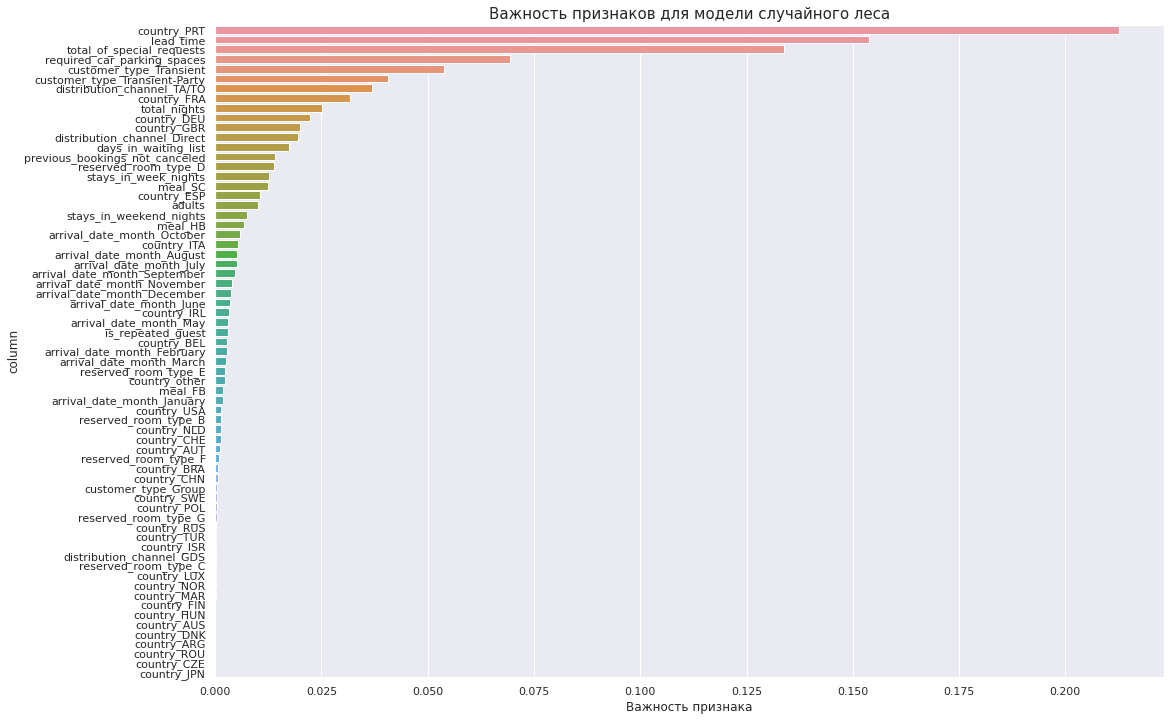

In [208]:
plt.figure(figsize=(17, 12))
sns.barplot(x='importance', y='column', data=importances)

plt.xlabel('Важность признака')
plt.title('Важность признаков для модели случайного леса', size=15)
plt.show()

In [209]:
importances[importances['column'] == 'country_CHN']

,column,importance
39,country_CHN,0.000742


In [210]:
importances = importances[importances['importance'] >= 0.000742]
importances.shape

(46, 2)

In [211]:
columns = importances['column']
X_train_smote = X_train_smote[columns.values]
X_train_smote.shape

(82022, 46)

In [213]:
X_test = X_test_ohe[columns.values]
X_test.shape

(32412, 46)

Повторно обучим модель по алгоритму случайный лес с учетом значимости признаков и лучших параметров:

In [214]:
model_rfc_best = RandomForestClassifier(random_state=RANDOM_STATE, criterion='entropy', max_depth=10,\
                                          n_estimators = 50, min_samples_leaf=3)
pipeline_rfc_best = make_pipeline(StandardScaler(), model_rfc_best)
pipeline_rfc_best.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=3, n_estimators=50,
                                        random_state=25))])

## 6.Тестирование модели

### 6.1 Тестирование 

In [215]:
predicted_test_rfc = pipeline_rfc_best.predict(X_test)
f1_rfc_test = f1_score(y_test, predicted_test_rfc)
f1_rfc_test

0.6670773563319546

Проверим изменение точности поргнозирования на тестовой выборке:

In [216]:
1 - f1_rfc_test/f1_rfc

0.14983154381944463

AUC-ROC: 0.8351072193022155


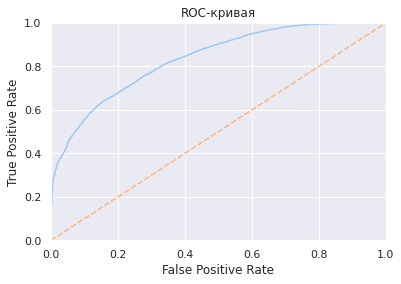

In [217]:
probabilities_test = pipeline_rfc_best.predict_proba(X_test)
probabilities_test = probabilities_test[:, 1]

print('AUC-ROC:', roc_auc_score(y_test, probabilities_test))

fpr, tpr, thresholds = roc_curve(y_test, probabilities_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Вывод:** На тестовой выборке модель показала снижение точности прогнозирования. Площадь под ROC-кривой имеет приемлимое значений.

### 6.2 Расчет прибыли с учетом депозита

Создадим тестовый набор с предсказаниями модели:

In [218]:
df_test_ml = df_test.copy()
df_test_ml['is_canceled_ml'] = predicted_test_rfc

Для расчета прибыли с учетом депозита, создадим функцию `profit_calculation_ml` и :

In [219]:
def profit_calculation_ml(row):
    if row['is_canceled'] == 1 and row['is_canceled_ml'] == 1:
        return (-row['price_room_type'] - row['one_price_service']) * row['seasonal_coefficient'] * 0.2 
    elif (row['is_canceled'] == 1 and row['is_canceled_ml'] == 0):
        return (-row['price_room_type'] - row['one_price_service']) * row['seasonal_coefficient']
    else:
        return (row['price_room_type'] * row['total_nights'] - row['one_price_service'] * ((1 + row['total_nights']) // 2)) * row['seasonal_coefficient']

In [220]:
def profit_summary_table_ml(df):
    df_profit = df[['is_canceled', 'is_canceled_ml', 'arrival_date_month', 'reserved_room_type', 'total_nights']]
    df_profit['price_room_type'] = df_profit['reserved_room_type'].map({'A': 1000, 'B': 800,\
                                                'C': 600, 'D': 550, 'E': 500, 'F': 450, 'G': 350})
    df_profit['one_price_service'] = df_profit['reserved_room_type'].map({'A': 400,\
                                                'B': 350, 'C': 350, 'D': 150, 'E': 150, 'F': 150, 'G': 150})
    df_profit['seasonal_coefficient'] = df_profit['arrival_date_month'].apply(season)
    df_profit['profit'] = df_profit.apply(profit_calculation_ml, axis=1)
    
    return df_profit

In [221]:
test_profit_ml = profit_summary_table_ml(df_test_ml)

In [222]:
profit_ml = test_profit_ml['profit'].sum()

In [223]:
print('Итоговая прибыль сети отелей за 8 месяцев:', profit_ml)

Итоговая прибыль сети отелей за 8 месяцев: 41077066.0


In [224]:
profit_ml - total_profit

9500816.0

**Вывод**: после внедрения системы внесения депозитов, прибыль отеля увеличилась. Разработка системы прогнозирования окупится.

## 7. Портрет «ненадёжного» клиента

По результам исследовательского анализа данных, "ненадежного" клиента можно описать следующими характеристиками:

- Страна клиента - Португалия;
- Отсутствие специальных отметок бронирования;
- Канал приобретения брони - TA/TO;
- Отсутствие в брони парковочного места;
- Временная разница между датой брони и датой заезда - более 270 дней;  
- Количество предыдущих отмен броней - более 13;  

## 8. Общий вывод

В ходе выполнения работы был проведена предобработка данных, исследовательский анализ, разработано три модели машинного обучения и расчитана прибыль сети отелей до внедрения депозита и после.  

Наилучшее качество предсказаний получили по алгоритму 'случайный лес'. Результаты прогнозирования данной модели были использованы для расчета прибыли с внедрением депозита. Разработка системы прогнозирования окупится.  

По результатам исследовательского анализа данных можно сделать следующие выводы о 'ненадежных' клиентах:  
- Наиболее значимый признак в отмене броней - страна клиента. Более 57% броней отменены клиентами из страны Португалия. Также следует обратить внимание на страны: Китай, Турция, Северная Македония, Венгрия, Марокко, Италия, Россия, Бразилия, Люксембург;
- Увеличение времени между датой бронирования и датой заезда увеличивает долю отмен броней. При временном промежутке более 250 дней болишство броней отменяется;  
- При распространении бронирований через туроператоров и турагентов наблюдается высокая доля отмен бронирований;  
- При отсутствии специальных отметок и парковочного места в бронировании высокая доля отмен броней.